# Tensorflow 데이터셋 만들기

https://www.tensorflow.org/tutorials/load_data/images 참고

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pathlib

## 이미지 불러오기

다음과 같은 폴더 구조를 만든다. (data 폴더 안에 best 와 faulty 폴더. 안에 이미지)

data/best/

data/faulty/
  
편의상 best(특)과 faulty(불량)으로 구분하였으며, 각 폴더에 30개의 이미지가 있다.

In [4]:
data_dir = "data"
data_dir = pathlib.Path(data_dir)

In [10]:
image_count = len(list(data_dir.glob('*/*.jpg'))) #이미지 총 개수
print(image_count)

60


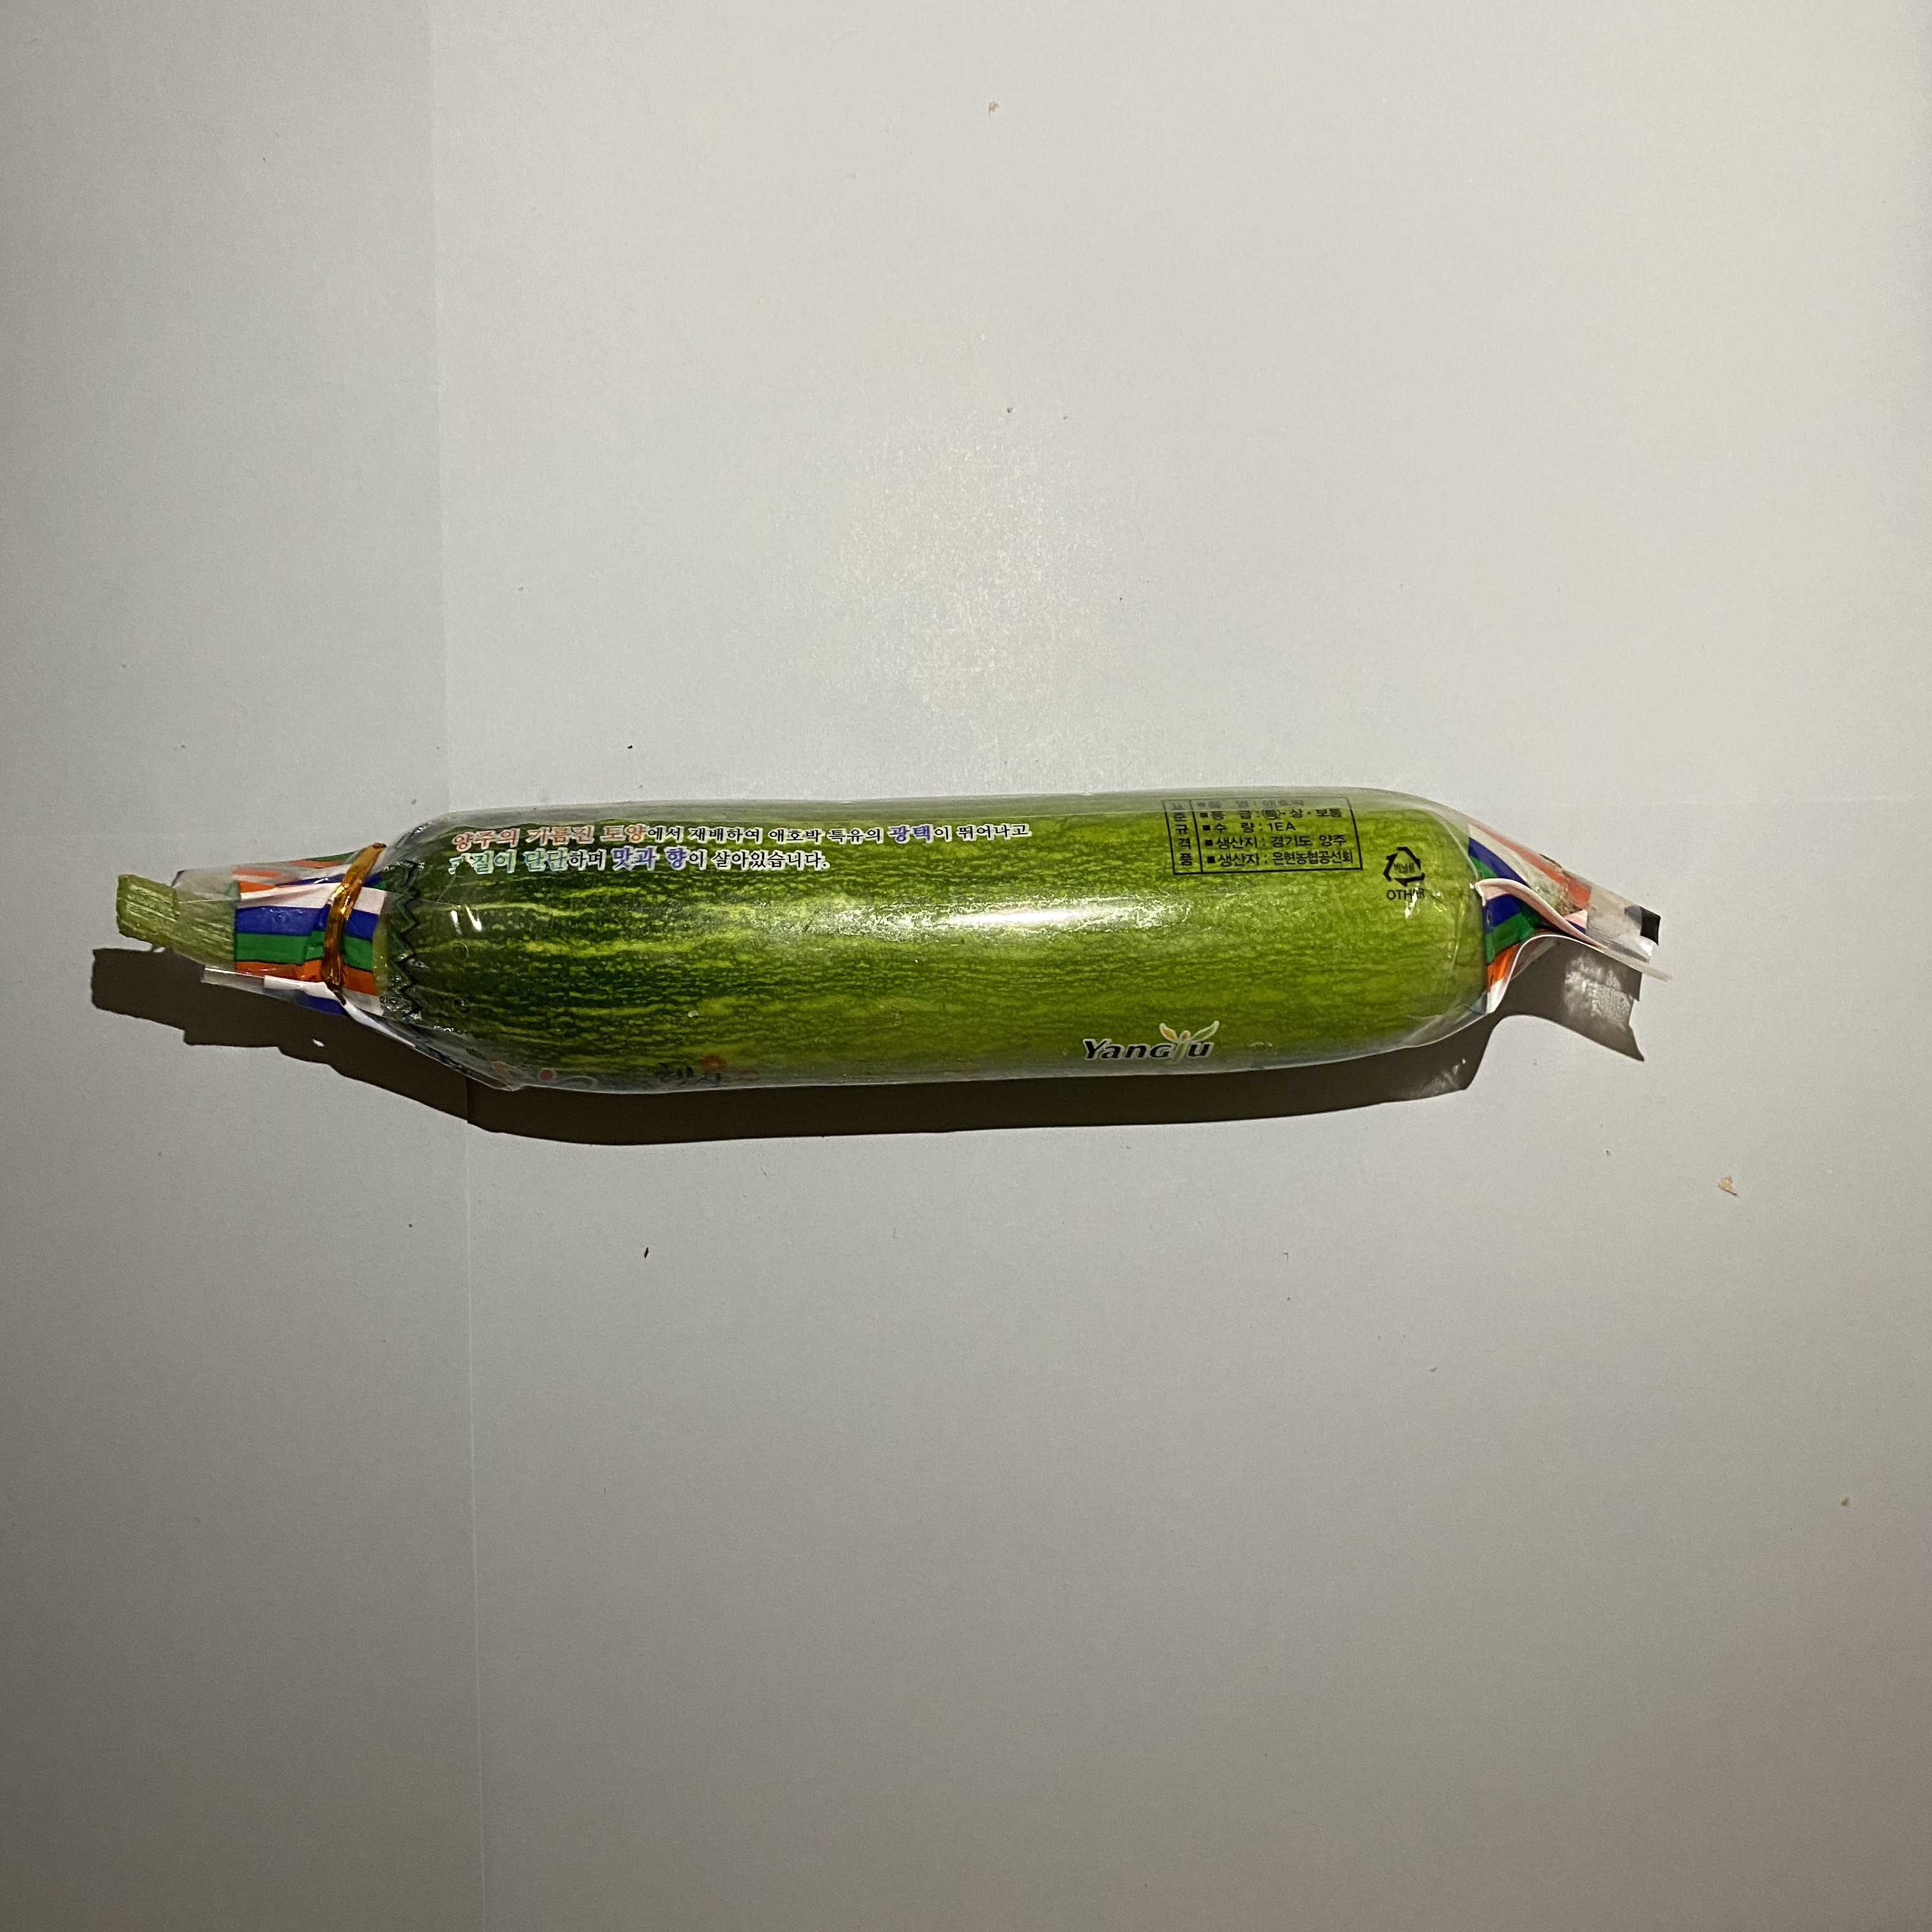

In [11]:
best = list(data_dir.glob('best/*')) # best 폴더 이미지 가져오기
PIL.Image.open(str(best[0]))

## Train, Validation(test) 데이터셋 나누기

폴더 명에 따른 라벨링을 해준다

In [7]:
batch_size = 32
img_height = 128
img_width = 128

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 60 files belonging to 2 classes.
Using 48 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 60 files belonging to 2 classes.
Using 12 files for validation.


In [13]:
class_names = train_ds.class_names
print(class_names)

['best', 'faulty']


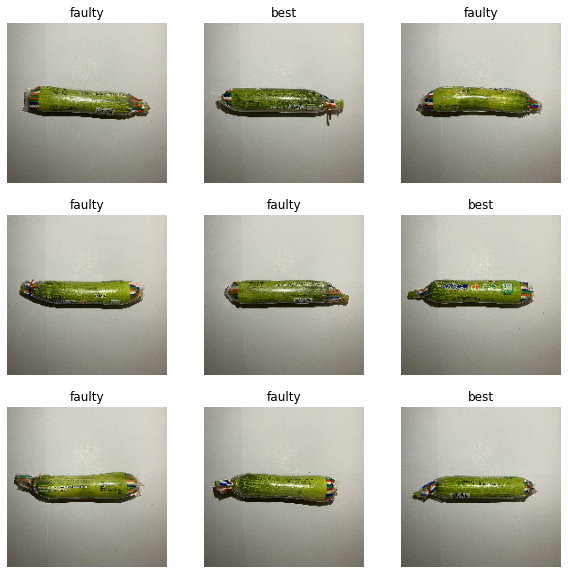

In [14]:
# training dataset 의 첫 9개 이미지
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## 데이터 정규화하기

RGB는 [0,255] 이기 때문에 [0,1]로 정규화하여 CNN 에 적합하게 만든다

In [15]:
from tensorflow.keras import layers

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [16]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


## 모델 학습 속도 향상

In [17]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Train a model

In [18]:
num_classes = 2

model = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
2/2 [==============================] - 1s 484ms/step - loss: 1.0126 - accuracy: 0.4792 - val_loss: 0.6761 - val_accuracy: 0.5833
Epoch 2/3
2/2 [==============================] - 0s 168ms/step - loss: 0.6869 - accuracy: 0.5208 - val_loss: 0.7136 - val_accuracy: 0.4167
Epoch 3/3
2/2 [==============================] - 0s 159ms/step - loss: 0.6931 - accuracy: 0.5208 - val_loss: 0.7104 - val_accuracy: 0.4167
